In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import scipy.linalg as linalg
%matplotlib inline

def plot_conservation_of_energy(orbit):
    print("Accuracy={}".format(linalg.norm(np.array([1.0,0.0]) - orbit[-1])))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot([p @ p for p in orbit])

    ax = plt.subplot(1, 2, 2)
    plt.plot(orbit[:, 0], orbit[:,1], 'o')
    ax.axis('square')
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.show()
    
A = np.array([[0,1],[-1,0]])
u = np.array([1.0,0.0])
N = 64

## Finite difference methods
Consider a classical Hamiltonian system - that of a undamped spring governed by the second order differential equation

\begin{align}
z'' + z = 0
\end{align}


\begin{split}
\pmatrix{ \frac{dz}{dt} \\ \frac{dr}{dt} } = \pmatrix{ z' \\ r' } = \pmatrix{0 & 1 \\ -1 & 0} \pmatrix{z \\ r} = A \pmatrix{z \\ r} = \pmatrix{ \frac{dH(z,r)}{dr} \\ \frac{dH(z,r)}{dz} }
\end{split}

where $H(z, r) = E(z) + K(r) = \frac{1}{2} z^2 + \frac{1}{2} r^2$. Let phase space $u = (z, r)$. We want to find a finite difference approximation to $u' = Au$ that is accurate and preserves total energy.

### Forward Euler

$\frac{u_{n+1} - u_n}{\Delta t} = A u_n \Rightarrow u_{n+1} = u_n + \Delta t A u_n = \left( I + \Delta t A \right) u_n$

We can see that forward Euler is not very accurate and also does not preserve energy since the orbit spirals away from the unit circle.

Accuracy=0.3600318484671192


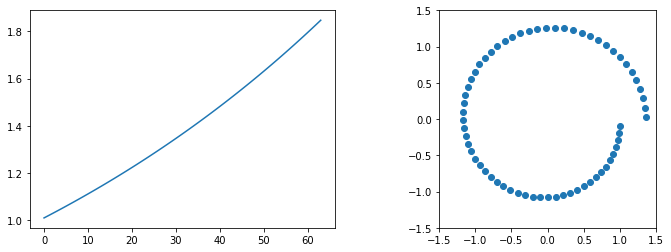

In [2]:
def f_euler(A, u, N):
    orbit = np.zeros((N,2))

    dt = 2*np.pi/N
    for i in range(N):
        u = u + dt * A @ u
        orbit[i] = u
    return orbit

orbit = f_euler(A, u, N)
plot_conservation_of_energy(orbit)

### The trapezoidal method

\begin{align}
\frac{u_{n+1} - u_n}{\Delta t} & = \frac{1}{2}  ( A u_{n+1} + A u_{n}) \\
u_{n+1} & = \left(I - \frac{\Delta t}{2} A \right)^{-1} \left(I + \frac{\Delta t}{2} A \right) u_{n} = B u_n
\end{align}

We can see that trapezoidal method is accurate and also preserve energy.

Accuracy=0.005039305635733781


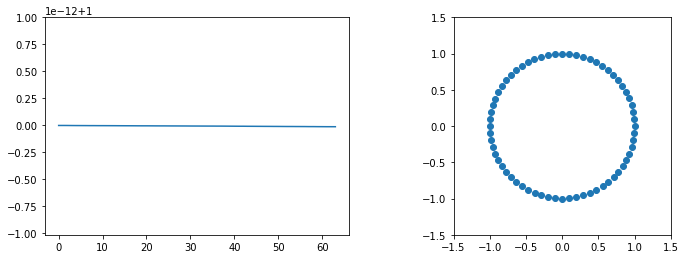

In [3]:
def trapezoidal(A, u, N):
    p = len(u)
    orbit = np.zeros((N,p))

    dt = 2*np.pi/N
    for i in range(N):
        u = linalg.inv(np.eye(p) - dt/2 * A) @ (np.eye(p) + dt/2 * A) @ u
        orbit[i] = u
    return orbit

orbit = trapezoidal(A, u, N)
plot_conservation_of_energy(orbit)

### The leapfrog method

The leapfrog method uses a second order difference to update un. The algorithm simplifies to the following explicit scheme:

- First take one half-step for $r$ = u[1]
- Then take a full step for $z$ = u[0]
- Then take one final half step for $r$ = u[1]

It performs as well as the trapezoidal method, with the advantage of being an explicit scheme and cheaper to calculate, so the leapfrog method is used in HMC.

Accuracy=0.0025229913808033464


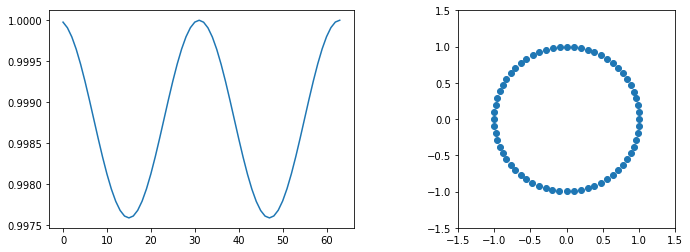

Accuracy=0.0050459787660545


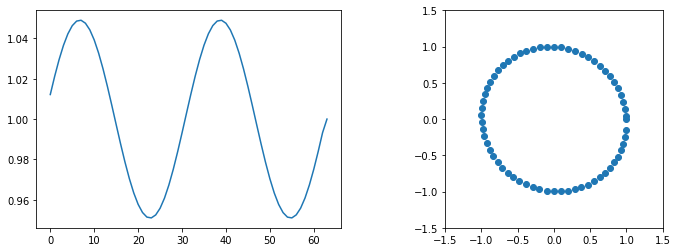

In [4]:
def leapfrog(A, u, N):
    orbit = np.zeros((N,2))

    dt = 2*np.pi/N
    for i in range(N):
        u[1] = u[1] + dt/2 * A[1] @ u  #(11.64)
        u[0] = u[0] + dt * A[0] @ u    #(11.65)
        u[1] = u[1] + dt/2 * A[1] @ u  #(11.66)
        orbit[i] = u
    return orbit

def leapfrog2(A, u, N):
    """
    If we don’t care about the intermediate steps, 
        it is more efficient to just take 1/2 steps at the beginning and end.
    """
    orbit = np.zeros((N,2))
    
    dt = 2*np.pi/N
    u[1] = u[1] + dt/2 * A[1] @ u
    for i in range(N-1):
        u[0] = u[0] + dt * A[0] @ u
        u[1] = u[1] + dt * A[1] @ u
        orbit[i] = u

    u[0] = u[0] + dt * A[0] @ u
    u[1] = u[1] + dt/2 * A[1] @ u
    orbit[N-1] = u
    return orbit

orbit = leapfrog(A, u, N)
plot_conservation_of_energy(orbit)

orbit = leapfrog2(A, u, N)
plot_conservation_of_energy(orbit)


We will explore how HMC works when the target distribution is bivariate normal centered at zero

\begin{align}
\mathbf{z} \sim N(0, \Sigma)
\end{align}

The potential energy or negative log likelihood is proportional to

\begin{align}
E(\mathbf{z}) = \frac{\mathbf{z}^\intercal\Sigma^{-1} \mathbf{z}}{2}
\end{align}

The kinetic energy is given by
\begin{align}
K(\mathbf{r}) = \frac{\mathbf{r}^\intercal \mathbf{r}}{2}
\end{align}

To find the time updates, we use the Hamiltonian equations
\begin{align}
\mathbf{z}' &= \frac{\partial E}{\partial v} &&= \mathbf{r} \\
\mathbf{r}' &= -\frac{\partial U}{\partial x} &&= -\Sigma^{-1} \mathbf{z} \\
\end{align}

That is
\begin{align}
\mathbf{u}' = \pmatrix{0 & 1 \\ -\Sigma^{-1} & 0} \mathbf{u} = A \mathbf{u}
\end{align}

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


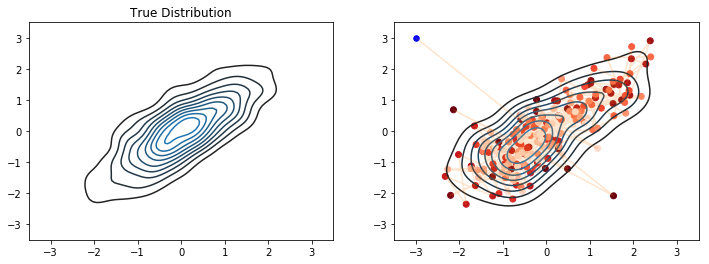

In [5]:
plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)

sigma = np.array([[1,0.8],[0.8,1]])
mu = np.zeros(2)
y = np.random.multivariate_normal(mu, sigma, 1000)
sns.kdeplot(y[:,0], y[:,1])
plt.axis([-3.5,3.5,-3.5,3.5])
ax.set_title('True Distribution')


def E(A, u0, v0, u, v):
    # Total energy
    return (u0 @ tau @ u0 + v0 @ v0) - (u @ tau @ u + v @ v)

def leapfrog(A, u, v, h, N):
    # Leapfrog finite difference scheme
    v = v - h/2 * A @ u
    for i in range(N-1):
        u = u + h * v
        v = v - h * A @ u

    u = u + h * v
    v = v - h/2 * A @ u
    return u, v

niter = 200

A = np.zeros((3,3))
tau = linalg.inv(sigma)
A[0,2] = 1
A[1:3,0:2] = -tau

orbit = np.zeros((niter+1, 2))
u = np.array([-3,3])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,size=2)
    u, v = leapfrog(tau, u, v0, h=0.01, N=100)

    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(A, u0, v0, u, v))
    r = np.random.rand()
    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

plt.subplot(1, 2, 2)        
sns.kdeplot(orbit[:,0], orbit[:,1])
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='blue', s=30) # inital point
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
plt.axis([-3.5,3.5,-3.5,3.5])
plt.show()